# Exercise 3.1: Audio steganography (ultrasonic AM)

This notebook:
- loads `Ex3_sound1.wav` ... `Ex3_sound4.wav`,
- detects which file has unusually high ultrasonic energy,
- estimates the ultrasonic carrier frequency,
- demodulates the AM envelope and plays the recovered code in an audible band.
- This notebook looks for unusually strong energy near the Nyquist limit (the top end of the spectrum) as a clue for ultrasonic hiding.
- The final step tries to recover an audible “message” by extracting the ultrasonic component and taking its amplitude envelope (AM demodulation).



In [1]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import wavfile
from scipy.signal import welch, butter, sosfiltfilt, hilbert
from IPython.display import Audio, display

plt.rcParams["figure.dpi"] = 120

## Function to find the target sound files



In [3]:
def find_audio_files():
    files = []
    files.extend(sorted(glob.glob("sounds/Ex3_sound*.wav")))
    seen, out = set(), []
    for f in files:
        if f not in seen:
            out.append(f); seen.add(f)
    return out

files = find_audio_files()
files

['sounds/Ex3_sound1.wav',
 'sounds/Ex3_sound2.wav',
 'sounds/Ex3_sound3.wav',
 'sounds/Ex3_sound4.wav',
 'sounds/Ex3_sound5.wav']

## Function to load wav files
- Down mix to mono sound to make the further process simpler.
- WAV files often store samples as integers (e.g., int16). The loader converts them to floating point `[-1, 1]` so that the DSP math is stable.
- Stereo files are averaged to mono, because the analysis is frequency-based and does not require spatial information.



In [4]:
def load_wav_mono(path: str):
    fs, x = wavfile.read(path)
    x = x.astype(np.float32)

    # Downmix to mono
    if x.ndim == 2:
        x = x.mean(axis=1)

    # Remove DC offset
    x = x - np.mean(x)
    return fs, x

fs0, x0 = load_wav_mono(files[0])
print("Example:", os.path.basename(files[0]), "fs=", fs0, "seconds=", len(x0)/fs0)

Example: Ex3_sound1.wav fs= 44100 seconds= 16.0


## Prepare helper functions
- `ultrasonic_band`: Determines the ultrasonic band depends on the provided sample rate.
- `ultrasonic_score`: Returns the rate of ultrasonic band in power spectrum density.
- `ultrasonic_band(fs)` chooses a search band close to Nyquist. For 44.1 kHz audio, Nyquist is 22.05 kHz, so the ultrasonic region is near ~18–22 kHz.
- `ultrasonic_score` computes a power spectral density (PSD) and integrates energy in two ranges:
  - ultrasonic band: `low..high`
  - audible+ultrasonic reference: `20 Hz..high`
  The score is the ratio of those energies.
- A large score does not prove steganography by itself. Some recordings genuinely contain strong high-frequency noise.



In [5]:
def ultrasonic_band(fs: int):
    """Pick a sensible ultrasonic search band for the current sample rate."""
    nyq = fs / 2.0
    low = min(18000.0, nyq * 0.80)
    high = max(low + 500.0, nyq - 400.0)  # keep margin from Nyquist
    return low, high

def ultrasonic_score(fs: int, x: np.ndarray):
    """Score = fraction of PSD energy in the ultrasonic band."""
    f, Pxx = welch(x, fs=fs, nperseg=8192, noverlap=4096, scaling="density")
    low, high = ultrasonic_band(fs)
    mask_u = (f >= low) & (f <= high)
    mask_a = (f >= 20) & (f <= high)

    u = np.trapezoid(Pxx[mask_u], f[mask_u])
    a = np.trapezoid(Pxx[mask_a], f[mask_a]) + 1e-12
    return float(u / a), (f, Pxx, low, high)

scores = []
debug_psd = {}

for path in files:
    fs, x = load_wav_mono(path)
    s, dbg = ultrasonic_score(fs, x)
    scores.append((s, path, fs))
    debug_psd[path] = dbg

scores_sorted = sorted(scores, reverse=True, key=lambda t: t[0])
scores_sorted

/var/folders/jf/l2jx78r533z87mc7z7zw20q80000gn/T/ipykernel_39081/609987274.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, x = wavfile.read(path)


[(0.1597313301085411, 'sounds/Ex3_sound4.wav', 48000),
 (0.0009531715160479167, 'sounds/Ex3_sound1.wav', 44100),
 (3.824049859357087e-09, 'sounds/Ex3_sound2.wav', 48000),
 (2.1036825003565147e-09, 'sounds/Ex3_sound3.wav', 48000),
 (7.189734333547707e-10, 'sounds/Ex3_sound5.wav', 44100)]

## Compare PSDs and highlight the ultrasonic band

- The PSD plot shows how signal power is distributed over frequency.
- Peaks close to the ultrasonic band may indicate a carrier tone used for amplitude modulation.



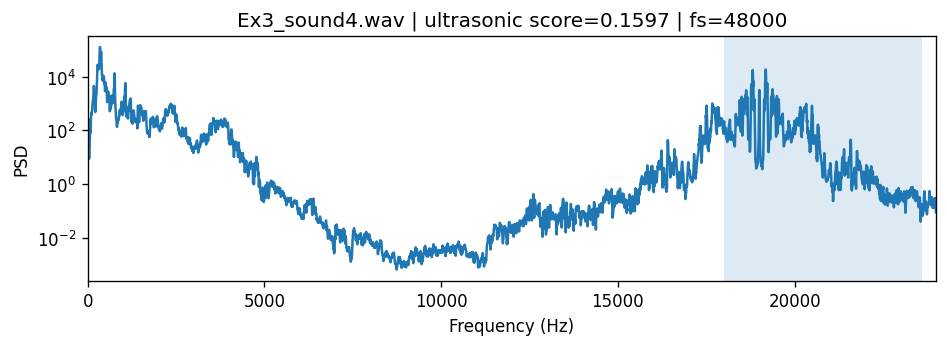

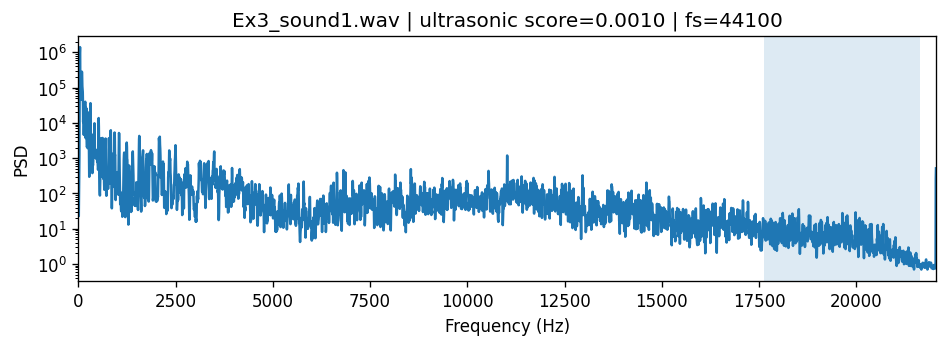

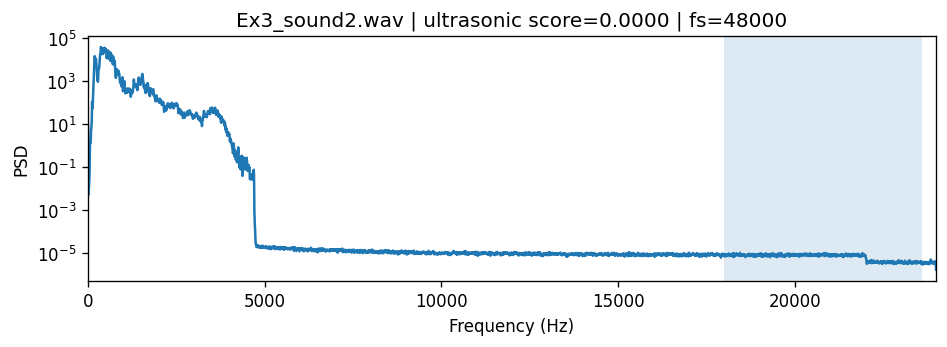

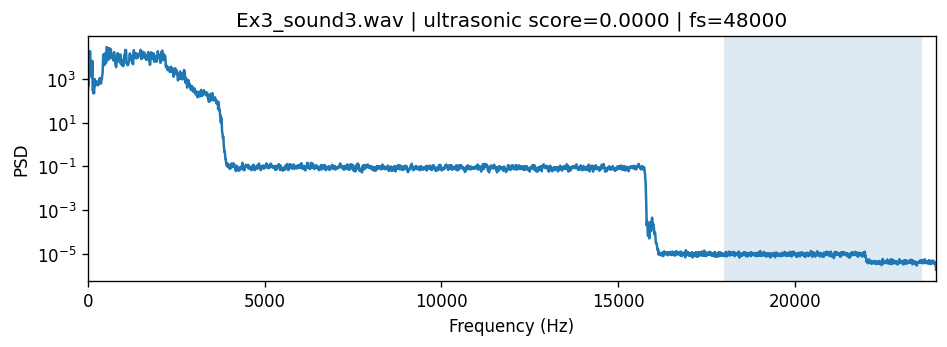

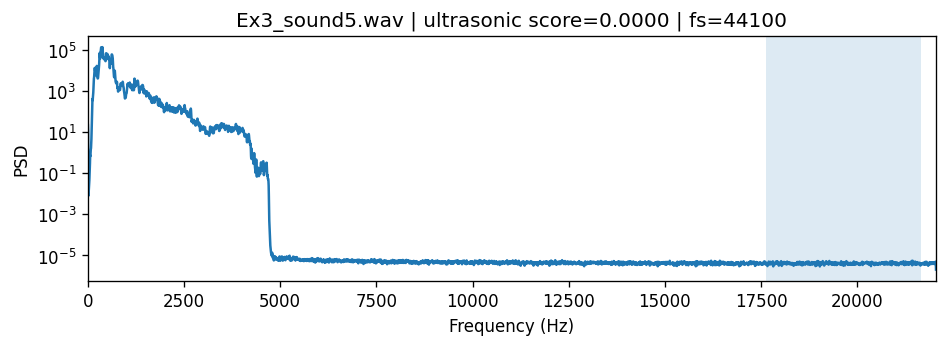

In [12]:
for s, path, fs in scores_sorted:
    f, Pxx, low, high = debug_psd[path]
    plt.figure(figsize=(8, 3))
    plt.semilogy(f, Pxx + 1e-18)
    plt.axvspan(low, high, alpha=0.15)
    plt.title(f"{os.path.basename(path)} | ultrasonic score={s:.4f} | fs={fs}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("PSD")
    plt.xlim(0, fs/2)
    plt.tight_layout()
    plt.show()

## Pick the most suspicious file (highest ultrasonic score)
- We rank files by the ultrasonic-energy ratio and pick the highest one as “most suspicious”.
- In practice, you might also inspect the plot: a narrow, sharp peak is more “carrier-like” than a broad noisy shelf.



In [7]:
suspicious_path = scores_sorted[0][1] if scores_sorted else None
suspicious_path

'sounds/Ex3_sound4.wav'

## Plot frequency spectrum of the suspicious file

- This spectrum plot is a sanity check: it helps you confirm whether there is a strong ultrasonic peak and where it sits.
- If the plot looks flat or the ultrasonic band is empty, the file may not contain an ultrasonic carrier (or the sample rate is too low).



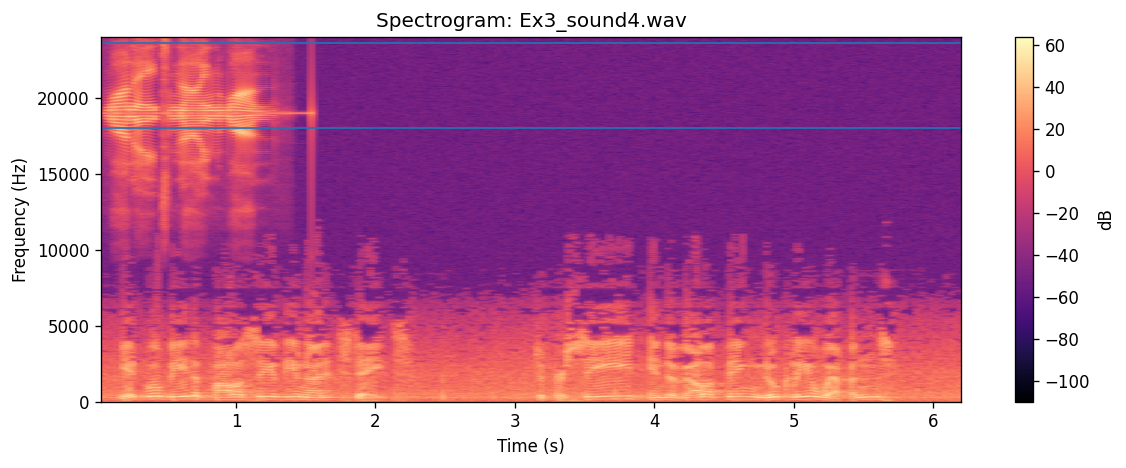

In [8]:
def plot_spectrogram(fs: int, x: np.ndarray, title: str):
    plt.figure(figsize=(10, 4))
    plt.specgram(x, NFFT=4096, Fs=fs, noverlap=3072, scale="dB", cmap="magma")
    low, high = ultrasonic_band(fs)
    plt.axhline(low, linewidth=1)
    plt.axhline(high, linewidth=1)
    plt.ylim(0, fs/2)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(label="dB")
    plt.tight_layout()
    plt.show()

fs, x = load_wav_mono(suspicious_path)
plot_spectrogram(fs, x, f"Spectrogram: {os.path.basename(suspicious_path)}")

## Find a carrier frequency in the ultrasonic band

- The carrier estimate is a simple peak-pick: find the maximum PSD value within the ultrasonic band.
- This works well when the carrier is a single strong tone. If the carrier drifts or is spread over a wider band, you may need a more robust estimator.



Estimated carrier (Hz): 18817.3828125


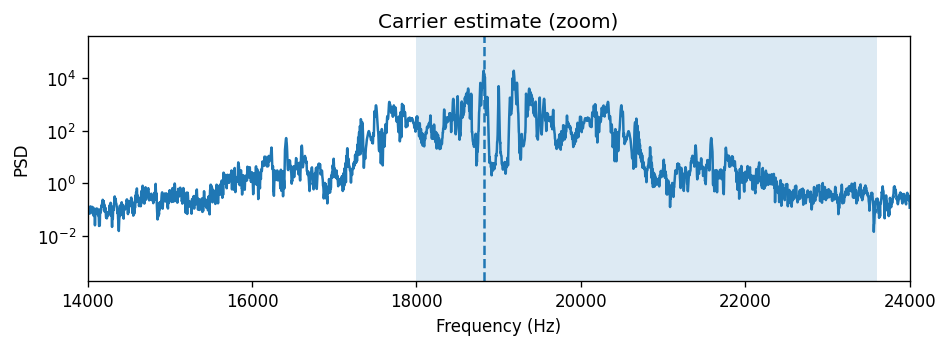

In [9]:
def estimate_carrier(fs: int, x: np.ndarray):
    """Estimate carrier frequency as the strongest peak in the ultrasonic band."""
    f, Pxx = welch(x, fs=fs, nperseg=16384, noverlap=8192, scaling="density")
    low, high = ultrasonic_band(fs)
    mask = (f >= low) & (f <= high)
    if not np.any(mask):
        return None, (f, Pxx, low, high)
    idx = np.argmax(Pxx[mask])
    fc = float(f[mask][idx])
    return fc, (f, Pxx, low, high)

fs, x = load_wav_mono(suspicious_path)
fc, dbg = estimate_carrier(fs, x)
print("Estimated carrier (Hz):", fc)
f, Pxx, low, high = dbg
plt.figure(figsize=(8, 3))
plt.semilogy(f, Pxx + 1e-18)
plt.axvline(fc, linestyle="--")
plt.axvspan(low, high, alpha=0.15)
plt.xlim(max(0, low-4000), min(fs/2, high+1000))
plt.title("Carrier estimate (zoom)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.tight_layout()
plt.show()

##  Generate audible sound of the hidden message
- Use a high-pass filter around the estimated carrier to extract the ultrasonic area from the original sound.
- Perform simple demodulation using the absolute value. This will convert the negative value of the wave to positive, possibly revealing hidden sound.
- Taking the absolute value (or an envelope detector) is a non-linear step that can turn a high-frequency AM signal into a baseband waveform.



In [11]:
import numpy as np

def highpass_fft(fs: int, x: np.ndarray, cutoff: float):
    X = np.fft.rfft(x)
    f = np.fft.rfftfreq(len(x), d=1/fs)
    X[f < cutoff] = 0
    return np.fft.irfft(X, n=len(x))

def demodulate_ultrasonic_band_fft(fs: int, x: np.ndarray, fc: float, hp_margin: float = -300.0):
    hp_cutoff = max(20.0, fc - hp_margin)
    y = highpass_fft(fs, x, hp_cutoff)
    return np.abs(y)

fs, x = load_wav_mono(suspicious_path)
fc, _ = estimate_carrier(fs, x)
msg = demodulate_ultrasonic_band_fft(fs, x, fc)
display(Audio(msg, rate=fs))